In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [6]:
transform = transforms.ToTensor()

In [7]:
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

100%|██████████| 1.65M/1.65M [00:00<00:00, 4.49MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.44MB/s]


In [8]:
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

In [9]:
img_height, img_width = train_dataset.data.shape[1], train_dataset.data.shape[2]
num_channels = 1 # Grayscale


In [10]:
class VAE(nn.Module):
    def __init__(self, latent_dim=2):
        super().__init__()
        self.latent_dim = latent_dim

        self.encoder_conv = nn.Sequential(
            # Input (N, 1, 28, 28)
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # -> (N, 64, 14, 14)
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Flatten() # -> (N, 64 * 14 * 14) = (N, 12544)
        )

        self.conv_shape = (64, 14, 14)


        self.encoder_dense = nn.Sequential(
            nn.Linear(self.conv_shape[0] * self.conv_shape[1] * self.conv_shape[2], 32),
            nn.ReLU()
        )

        self.fc_mu = nn.Linear(32, latent_dim)
        self.fc_log_var = nn.Linear(32, latent_dim)
        self.decoder_dense = nn.Sequential(
            nn.Linear(latent_dim, self.conv_shape[0] * self.conv_shape[1] * self.conv_shape[2]),
            nn.ReLU()
        )

        self.decoder_conv = nn.Sequential(
            nn.Unflatten(1, self.conv_shape),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1), # -> (N, 32, 28, 28)
            nn.ReLU(),
            nn.ConvTranspose2d(32, num_channels, kernel_size=3, padding=1), # -> (N, 1, 28, 28)
            nn.Sigmoid()
        )

    def reparameterize(self, mu, log_var):

        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):

        x = self.encoder_conv(x)
        x = self.encoder_dense(x)
        mu = self.fc_mu(x)
        log_var = self.fc_log_var(x)

        # Reparameterization
        z = self.reparameterize(mu, log_var)

        # Decoder path
        x_recon = self.decoder_dense(z)
        x_recon = self.decoder_conv(x_recon)

        return x_recon, mu, log_var


In [11]:
def vae_loss(recon_x, x, mu, log_var):

    recon_loss = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')

    kld_loss = -0.0005 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    return (recon_loss + kld_loss) / x.size(0)


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(latent_dim=2).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
EPOCHS = 10

print(f"\n--- Training VAE on {device} ---")
for epoch in range(1, EPOCHS + 1):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()

        recon_batch, mu, log_var = model(data)
        loss = vae_loss(recon_batch, data, mu, log_var)

        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    avg_loss = train_loss / len(train_loader)
    print(f'====> Epoch: {epoch} Average loss: {avg_loss:.4f}')

print("Training complete.")



--- Training VAE on cuda ---
====> Epoch: 1 Average loss: 177.0769
====> Epoch: 2 Average loss: 155.4062
====> Epoch: 3 Average loss: 150.8383
====> Epoch: 4 Average loss: 148.5036
====> Epoch: 5 Average loss: 146.9916
====> Epoch: 6 Average loss: 145.6799
====> Epoch: 7 Average loss: 144.8344
====> Epoch: 8 Average loss: 143.9523
====> Epoch: 9 Average loss: 143.2135
====> Epoch: 10 Average loss: 142.7047
Training complete.


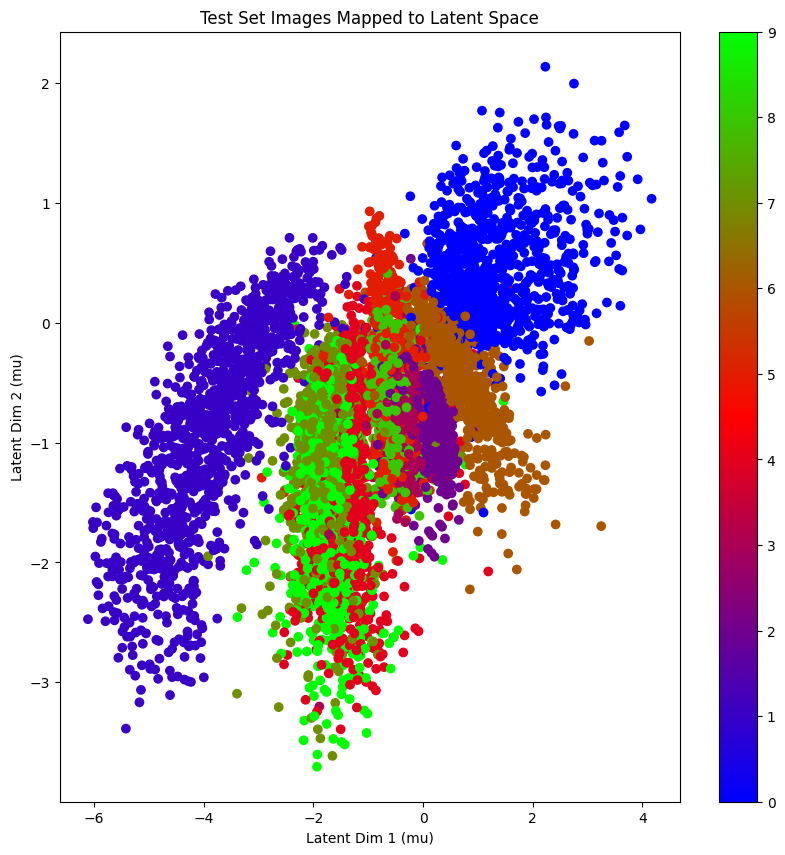

In [13]:
all_mu = []
all_labels = []
with torch.no_grad():
    for data, labels in test_loader:
        data = data.to(device)
        # We only need mu for this plot
        recon, mu, log_var = model(data)
        all_mu.append(mu.cpu())
        all_labels.append(labels.cpu())

all_mu = torch.cat(all_mu, dim=0)
all_labels = torch.cat(all_labels, dim=0)

plt.figure(figsize=(10, 10))
plt.scatter(all_mu[:, 0], all_mu[:, 1], c=all_labels, cmap='brg')
plt.xlabel('Latent Dim 1 (mu)')
plt.ylabel('Latent Dim 2 (mu)')
plt.colorbar()
plt.title('Test Set Images Mapped to Latent Space')
plt.show()



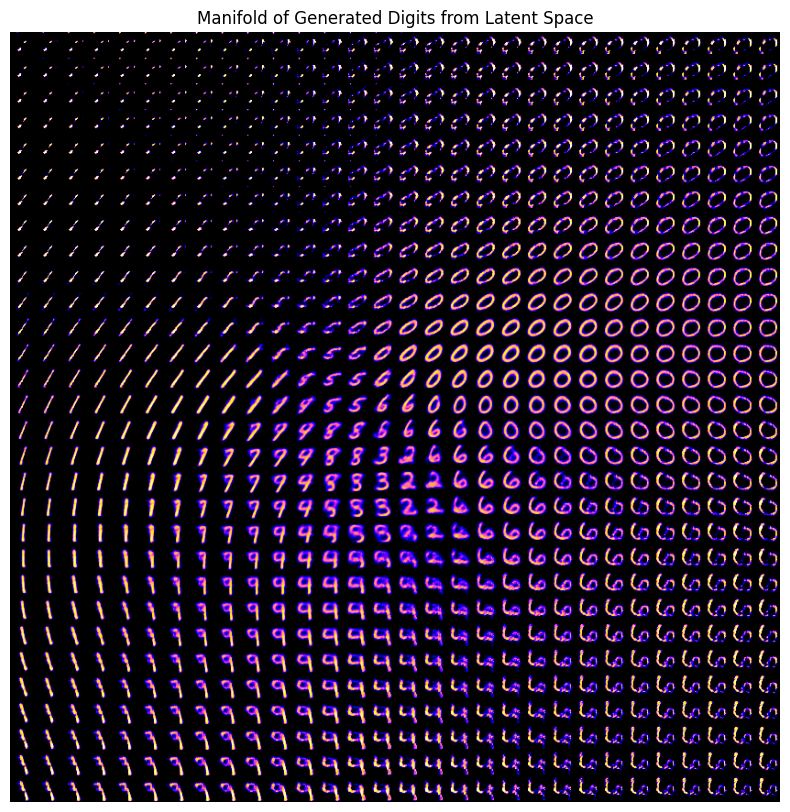

In [16]:
n = 30  # Number of images per side of the grid
figure = np.zeros((img_width * n, img_height * n, num_channels))


grid_x = np.linspace(-5, 5, n)
grid_y = np.linspace(-5, 5, n)[::-1]

with torch.no_grad():
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], device=device, dtype=torch.float32)


            x_decoded_flat = model.decoder_dense(z_sample)
            x_decoded = model.decoder_conv(x_decoded_flat)

            digit = x_decoded[0].cpu().numpy().reshape(img_height, img_width, num_channels)
            figure[i * img_height: (i + 1) * img_height,
                   j * img_width: (j + 1) * img_width] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure.squeeze(), cmap='gnuplot2')
plt.title('Manifold of Generated Digits from Latent Space')
plt.axis('off')
plt.show()

# Single Digit Visualization

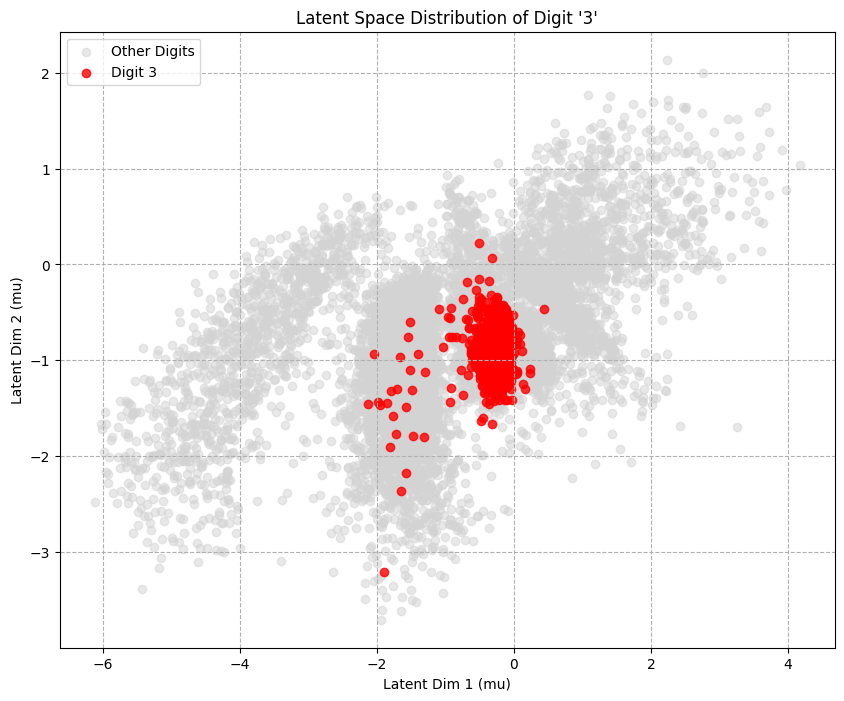

In [18]:

# --- Configuration ---
DIGIT_TO_VISUALIZE = 3

# --- Extract latent means and labels from the test set ---
all_mu = []
all_labels = []
with torch.no_grad():
    for data, labels in test_loader:
        data = data.to(device)
        _, mu, _ = model(data)
        all_mu.append(mu.cpu())
        all_labels.append(labels.cpu())

all_mu = torch.cat(all_mu, dim=0)
all_labels = torch.cat(all_labels, dim=0)

# --- Create the plot ---
plt.figure(figsize=(10, 8))


other_digits_mask = (all_labels != DIGIT_TO_VISUALIZE)
plt.scatter(
    all_mu[other_digits_mask, 0],
    all_mu[other_digits_mask, 1],
    c='lightgray',
    alpha=0.5,
    label='Other Digits'
)


chosen_digit_mask = (all_labels == DIGIT_TO_VISUALIZE)
plt.scatter(
    all_mu[chosen_digit_mask, 0],
    all_mu[chosen_digit_mask, 1],
    c='red',
    alpha=0.8,
    label=f'Digit {DIGIT_TO_VISUALIZE}'
)

plt.xlabel('Latent Dim 1 (mu)')
plt.ylabel('Latent Dim 2 (mu)')
plt.title(f"Latent Space Distribution of Digit '{DIGIT_TO_VISUALIZE}'")
plt.legend()
plt.grid(True, linestyle='--')
plt.show()

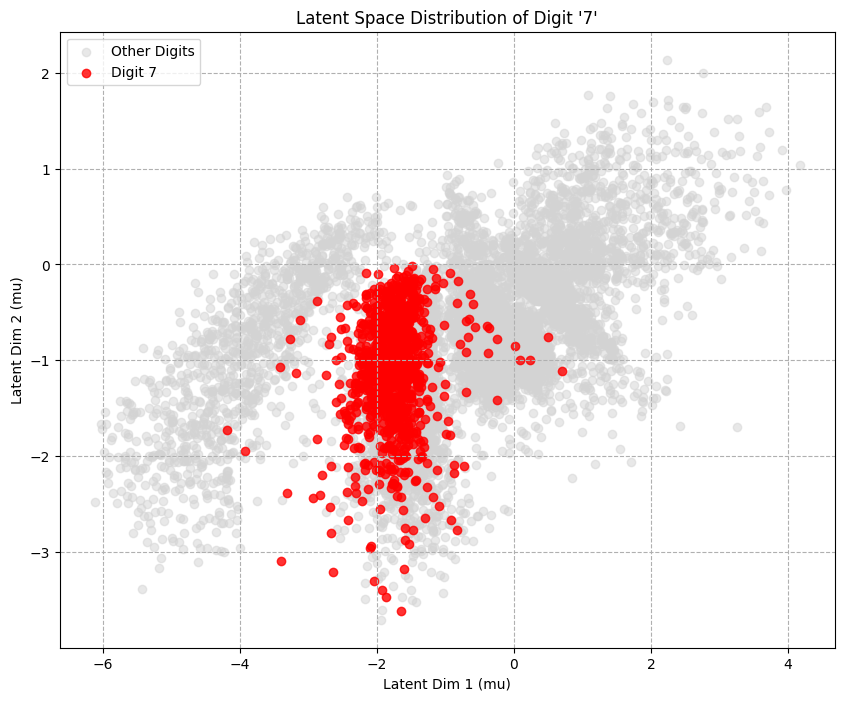

In [19]:

# --- Configuration ---
DIGIT_TO_VISUALIZE = 7

# --- Extract latent means and labels from the test set ---
all_mu = []
all_labels = []
with torch.no_grad():
    for data, labels in test_loader:
        data = data.to(device)
        _, mu, _ = model(data)
        all_mu.append(mu.cpu())
        all_labels.append(labels.cpu())

all_mu = torch.cat(all_mu, dim=0)
all_labels = torch.cat(all_labels, dim=0)

# --- Create the plot ---
plt.figure(figsize=(10, 8))


other_digits_mask = (all_labels != DIGIT_TO_VISUALIZE)
plt.scatter(
    all_mu[other_digits_mask, 0],
    all_mu[other_digits_mask, 1],
    c='lightgray',
    alpha=0.5,
    label='Other Digits'
)


chosen_digit_mask = (all_labels == DIGIT_TO_VISUALIZE)
plt.scatter(
    all_mu[chosen_digit_mask, 0],
    all_mu[chosen_digit_mask, 1],
    c='red',
    alpha=0.8,
    label=f'Digit {DIGIT_TO_VISUALIZE}'
)

plt.xlabel('Latent Dim 1 (mu)')
plt.ylabel('Latent Dim 2 (mu)')
plt.title(f"Latent Space Distribution of Digit '{DIGIT_TO_VISUALIZE}'")
plt.legend()
plt.grid(True, linestyle='--')
plt.show()

# New section

Calculated average distribution for digit '6'.
  - Average mu: [ 0.62 -0.43]
  - Average log_var: [-18.79 -19.1 ]


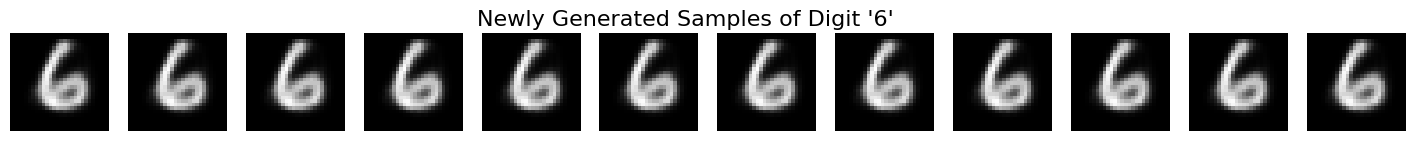

In [24]:


# --- Configuration ---
DIGIT_TO_GENERATE = 6
NUM_SAMPLES = 12

# --- Find the average distribution for the chosen digit ---
# We need to collect all mu and log_var vectors for the chosen digit
class_mu = []
class_log_var = []
with torch.no_grad():
    for data, labels in test_loader:
        data = data.to(device)
        _, mu, log_var = model(data)

        # Filter for the specific digit
        mask = (labels == DIGIT_TO_GENERATE)
        if mask.any():
            class_mu.append(mu[mask].cpu())
            class_log_var.append(log_var[mask].cpu())

# Calculate the average mu and log_var for the class
avg_mu = torch.cat(class_mu).mean(dim=0)
avg_log_var = torch.cat(class_log_var).mean(dim=0)

print(f"Calculated average distribution for digit '{DIGIT_TO_GENERATE}'.")
print(f"  - Average mu: {np.round(avg_mu.numpy(), 2)}")
print(f"  - Average log_var: {np.round(avg_log_var.numpy(), 2)}")

# --- Generate new samples from this specific distribution ---
model.eval()
with torch.no_grad():
    z_samples = model.reparameterize(
        avg_mu.unsqueeze(0).repeat(NUM_SAMPLES, 1), # Repeat mu for each sample
        avg_log_var.unsqueeze(0).repeat(NUM_SAMPLES, 1) # Repeat log_var for each sample
    ).to(device)

    # Decode the latent samples
    generated_images = model.decoder_dense(z_samples)
    generated_images = model.decoder_conv(generated_images).cpu()

# --- Plot the results ---
fig, axes = plt.subplots(1, NUM_SAMPLES, figsize=(NUM_SAMPLES * 1.5, 1.5))
for i, ax in enumerate(axes.flat):
    ax.imshow(generated_images[i].view(28, 28), cmap='gray')
    ax.axis('off')
plt.suptitle(f"Newly Generated Samples of Digit '{DIGIT_TO_GENERATE}'", fontsize=16)
plt.show()